In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.initializers import GlorotNormal

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
import seaborn as sns

from sklearn.model_selection import cross_val_score, KFold

from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

def randomize_index(X0, y):
  train_idx = np.random.permutation(len(y))
  X0 = X0[train_idx]
  y = y[train_idx]
  return X0, y

Mounted at /content/drive


In [ ]:
item_names = ['Asahi_Fruit_Milk',
              'Kabaya_Fruit_Soda',
              'Kanro_Matcha_Latte',
              'Kasugai_Grape_Strawberry_Muscat',
              'Kasugai_Lychee_Mango_Strawberry',
              'Kasugai_Manuka_Honey',
              'Kasugai_Matcha_Milk',
              'Kasugai_Muscat',
              'Kasugai_Sumiyaki_Coffee',
              'Kasugai_Watermelon',
              'Kopiko_Cappuccino',
              'Mammos_Korean_Ginseng',
              'Matdongsan_Peanut_Crunch',
              'Nobel_Melon',
              'Nobel_Milk',
              'Nobel_Red_Bean',
              'Pepero_Almond',
              'Plushy_Cow_Milk',
              'Plushy_Cow_Strawberry',
              'Pocky_Chocolate_9_Pack',
              'Pocky_Matcha',
              'Pocky_Strawberry_9_Pack',
              'Sakkuto_Matcha',
              'Choco_Mont',
              'Buldak_Instant',
              'Halo_Green_Laver',
              'HMart_Laver_Chip',
              'Imuraya_Castella_Matcha',
              'Imuraya_Castella_Original',
              'Orion_Marine_Boy',
              'JBasket_Boba_Black',
              'JBasket_Boba_Matcha',
              'JBasket_Boba_Taro',
              'Gunpang',
              'Jujube_Tea',
              'Korean_Red_Ginseng_Candy_Gold',
              'Korean_Red_Ginseng_Jelly_Gold',
              'Honey_Butter_Chip',
              'Solomons_Seal_Tea',
              'Young_Ji_Tea',
              'Chrysanthemum_Tea',
              'Shin_Original',
              'Shin_Gold',
              'Bibimmyun',
              'Chapaghetti',
              'Neoguri',
              'Buldak_2x',
              'MNM_Mint',
              'Smoked_Flavor_Grilled_Squid',
              'Vitamin_Code_Grow_Bone']

In [ ]:
data_dir = '/content/drive/MyDrive/Price Checker Models/'
data_name = 'datafile.npz'
data = np.load(data_dir + data_name)
Xtrain = data['Xtrain']
ytrain = data['ytrain']
Xtest = data['Xtest']
ytest = data['ytest']

item_names = data['item_names']
#Xtrain, ytrain = randomize_index(Xtrain, ytrain)

ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)
num_classes = len(ytest[0])

(-0.5, 119.5, 119.5, -0.5)

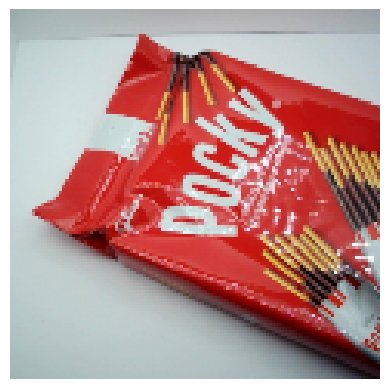

In [ ]:
plt.imshow(Xtrain[19*408+17].astype(np.float32))
plt.axis('off')

In [ ]:
# =========================================
# loading validation/testing data
# =========================================

directory_name = '/content/drive/MyDrive/Item Image Data 120/'

# specify how many classes to classify
num_classes = len(item_names)

for i in range(num_classes):
  directory = directory_name + item_names[i] + '_120_Test.npz'
  data = np.load(directory)
  if i == 0:
    Xtest = data['X']
    ytest = i*np.ones( (len(data['X']), 1) )
  else:
    Xtest = np.vstack(( Xtest, data['X'] ))
    ytest = np.vstack( (ytest, i*np.ones( (len(data['X']), 1) )) )

y = ytest
ytest = to_categorical(ytest)
print('Xtest:\ndata type',Xtest.dtype, '\ntakes up:',Xtest.nbytes/1073741824, 'GB')

Xtest:
data type float16 
takes up: 0.20116567611694336 GB


In [ ]:
# =========================================
# loading training data
# =========================================

randidx = np.random.permutation(408)

# select "data_count" number of random image samples for training from each class
data_count = 408
augment_data = 0

for i in range(num_classes):
  directory = directory_name + item_names[i] + '_120.npz'
  data = np.load(directory)

  if i == 0:
    Xtrain = data['X'][randidx[:data_count]]
    ytrain = i*np.ones( (data_count, 1))

  else:
    Xtrain = np.vstack(( Xtrain, data['X'][randidx[:data_count]] ))
    ytrain = np.vstack( (ytrain, i*np.ones( (data_count, 1) )) )

ytrain = to_categorical(ytrain)
Xtrain, ytrain = randomize_index(Xtrain, ytrain)

print('Xtrain:\ndata type:',Xtrain.dtype, '\ntakes up:',Xtrain.nbytes/1073741824, 'GB')

Xtrain:
data type: float16 
takes up: 1.6415119171142578 GB


In [ ]:
from keras.applications import ResNet50
from keras.layers import Dense, Flatten
from keras.models import Model

# Load the pre-trained ResNet50 model without the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add a new fully connected layer
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)  # You can adjust the number of units in the Dense layer
output = Dense(num_classes, activation='softmax')(x)  # Assuming you have 'num_classes' output classes

# Create the new model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

In [ ]:
# MODEL INITIALIZATION
input_shape = Xtest.shape[1:]

filter_qty = [96, 136]
filter_dim = [3, 3]
filter_std = [3, 3]
pool_dim = [3, 3]
pool_std = [3, 3]
conv_activation = 'relu'

hl_neurons = [96, 96]
fcnn_activation = 'relu'
dropout = 0.4

model = Sequential()
for j in range(len(filter_qty)):
    model.add(Conv2D(filters = filter_qty[j], kernel_size = (filter_dim[j], filter_dim[j]),
                     strides = (filter_std[j], filter_std[j]), padding = 'valid',
                     activation = conv_activation, input_shape = (input_shape)))

    model.add(MaxPooling2D(pool_size = (pool_dim[j], pool_dim[j]),
                          strides = (pool_std[j], pool_std[j])))
model.add(Flatten())

for j in range(len(hl_neurons)):
    model.add(Dense(hl_neurons[j],
                    activation = fcnn_activation))
    model.add(Dropout(dropout))
model.add(Dense(num_classes, activation = 'softmax'))

model.compile(optimizer = 'adam',
              loss ='categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 40, 96)        2688      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 136)         117640    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 1, 136)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 136)               0         
                                                                 
 dense (Dense)               (None, 96)                1

In [ ]:
save_dir = '/content/drive/MyDrive/Price Checker Models/'
save_name = 'best_model.h5'
save_best_model = ModelCheckpoint(filepath = save_dir + save_name,
                                  monitor = 'val_accuracy',
                                  save_best_only = True)

history = model.fit(Xtrain, ytrain,
                    epochs = 60,
                    batch_size = 36,
                    validation_data = [Xtest, ytest])#,
                    #callbacks = [save_best_model])

val_acc = history.history['val_accuracy']
train_acc = history.history['accuracy']

# history = model.fit(Xtrain, ytrain,
#                     epochs = 15,
#                     batch_size = 8,
#                     validation_data = [Xtest, ytest],
#                     callbacks = [save_best_model])

# val_acc = np.concatenate((val_acc, history.history['val_accuracy']))
# train_acc = np.concatenate((train_acc, history.history['accuracy']))

Epoch 1/60


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 120, 120, 3)


In [ ]:
model = load_model(save_dir + save_name)
loss, accuracy = model.evaluate(Xtest, ytest)
yhat = np.argmax(model.predict(Xtest), axis = 1)

if accuracy > 0.8:
  save_name_0 = 'M'+str(num_classes)+ '_' + str(int(1000*np.round(accuracy*100, 3))) + '.h5'
  model.save(save_dir + save_name_0)

79/79 [==============================] - 0s 4ms/step


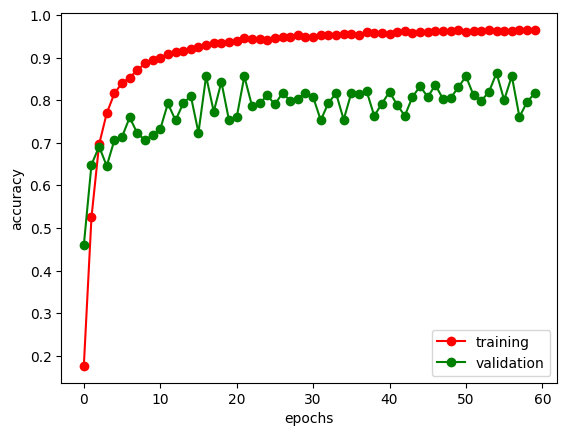

In [ ]:
plt.plot(train_acc,'ro-', label = 'training')
plt.plot(val_acc,'go-', label = 'validation')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
np.savez(save_dir + 'model_acc.npz', training_accuracy = train_acc, validation_accuracy = val_acc)

In [ ]:
np.shape(np.concatenate((history.history['accuracy'], history.history['accuracy'])))

(120,)

In [ ]:
print(classification_report(y, yhat))
recall_per_class = recall_score(y, yhat, average = None)

NameError: name 'y' is not defined

In [ ]:
bad_items = np.array(np.where(recall_per_class < 0.75)).flatten()

for i in range(len(bad_items)):
  print(item_names[bad_items[i]])

pp = np.delete(recall_per_class, bad_items)
print('\naccuracy without bad items:',np.round(np.mean(pp)*100,2),'%')

In [ ]:
plt.plot(history.history['accuracy'], 'ro-',label = 'training accuracy')
plt.plot(history.history['val_accuracy'], 'go-',label = 'validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.title(f'accuracy: {np.round(100*accuracy,2)}%')

In [ ]:
i = np.random.randint(len(Xtest))
plt.imshow(Xtest[i].astype(np.float64))
plt.title(item_names[yhat[i]])